#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<b>Описание данных</b>

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Описание хода работы

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Настройки рабочей тетради

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

from lightgbm import LGBMRegressor

import os

In [2]:
# Настройки библиотек

pd.options.mode.chained_assignment = None  # default='warn'
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [3]:
# Путь к директории с данными

path = 'datasets/'

## Подготовка

In [4]:
data = pd.read_csv(os.path.join(path, 'taxi.csv'))

display(data)
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.index = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.drop('datetime', axis=1)
data.sort_index(inplace=True)
data = data.resample('1H').sum()
print('Индексы расположены в порядке возрастания:', data.index.is_monotonic)
print('Количество пропусков:', data.isna().sum())
data

Индексы расположены в порядке возрастания: True
Количество пропусков: num_orders    0
dtype: int64


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<b>Вывод</b>

Представлены данные за полгода, в период с начала марта 2018 по конец августа 2018. Данные расположены по возрастанию, пропусков нет.

## Анализ

Для начала, чтобы получить общее представление о предоставленных данных построим график скользящего среднего (возьмём окно равное 24 часам) и тренда.

### Анализ всего периода

In [6]:
data_for_analys = data.copy()

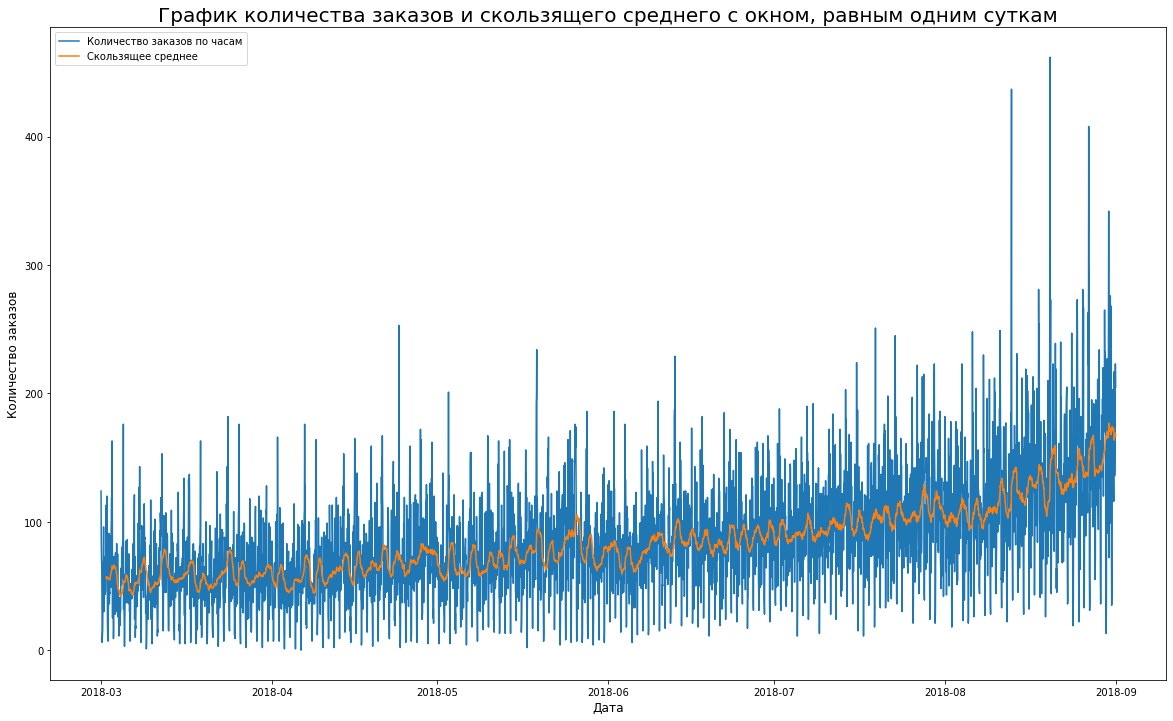

In [7]:
data_for_analys['rolling_mean'] = data_for_analys.rolling(24).mean() 

plt.figure(figsize=(20, 12))
plt.plot(data_for_analys.index, data_for_analys['num_orders'], label='Количество заказов по часам')
plt.plot(data_for_analys.index, data_for_analys['rolling_mean'], label='Скользящее среднее')
plt.title('График количества заказов и скользящего среднего с окном, равным одним суткам', fontsize = 20)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Количество заказов', fontsize = 12)
plt.legend()
plt.show()

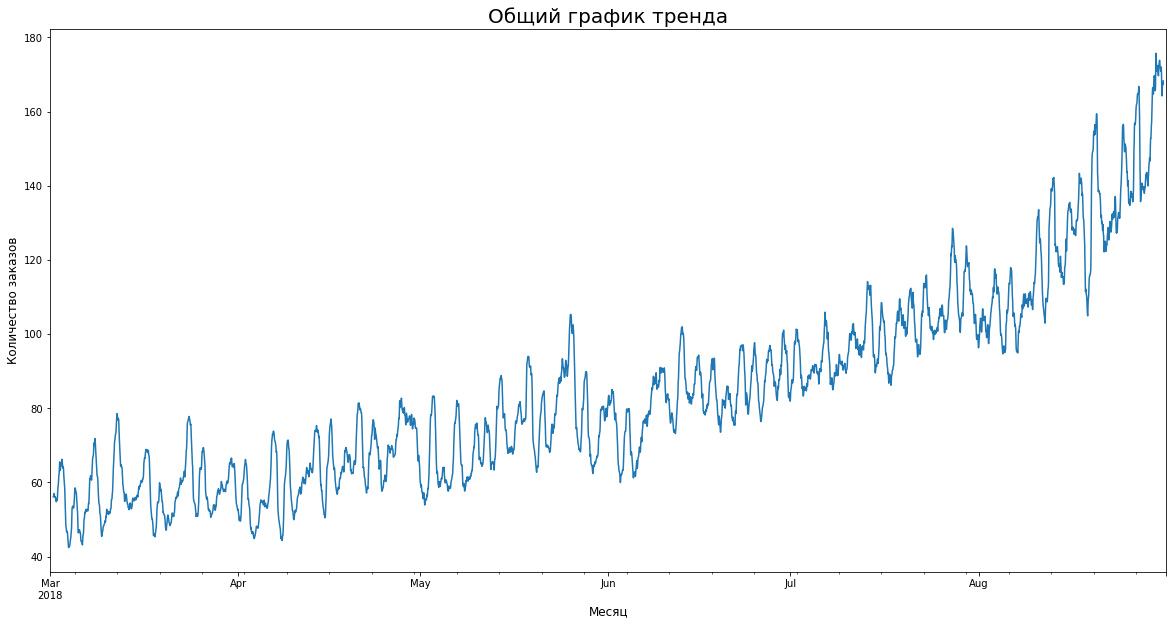

In [8]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(20, 10))
decomposed.trend.plot()
plt.title('Общий график тренда', fontsize = 20)
plt.xlabel('Месяц', fontsize = 12)
plt.ylabel('Количество заказов', fontsize = 12)
plt.show()

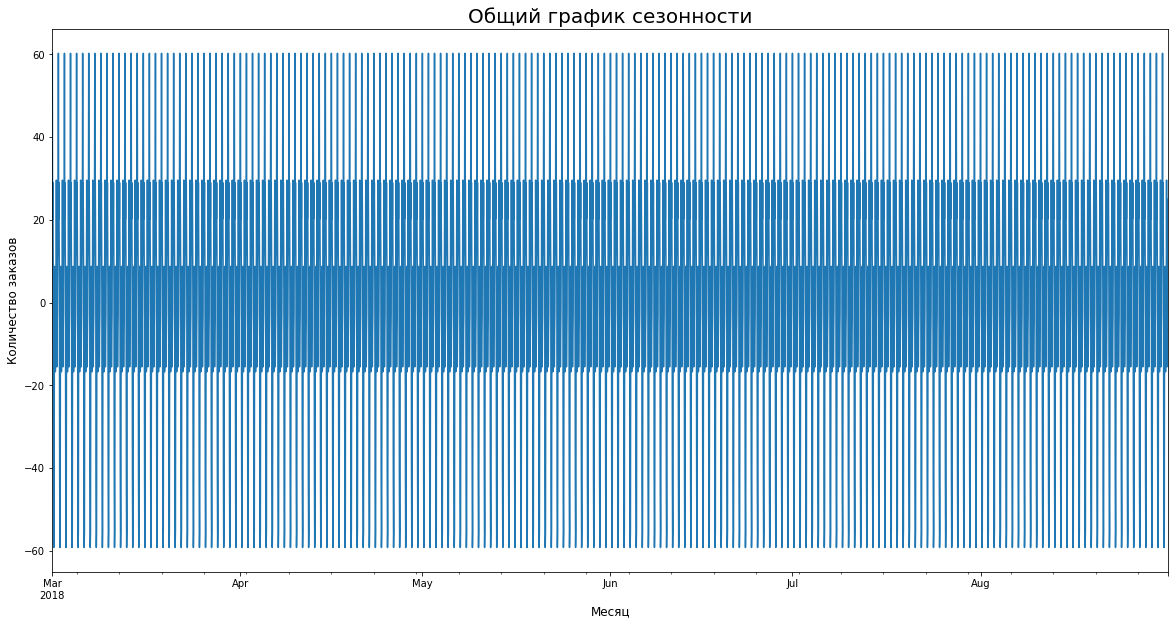

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(20, 10))
decomposed.seasonal.plot()
plt.title('Общий график сезонности', fontsize = 20)
plt.xlabel('Месяц', fontsize = 12)
plt.ylabel('Количество заказов', fontsize = 12)
plt.show()

<b>Вывод</b>

И скользящее среднее, и тренд показывают, что количество заказов, в общем, растёт в течение всего периода, однако оба графика идут скачками. Можно предположить, что эти скачки связаны с графиком прилёта самолётов: очевидно, что в час, когда самолёт прилетает в аэропорт, заказов будет больше. Из графика сезонности понятно, что присутствуют скачки разных уровней и все они повторяются за какой-то короткий промежуток времени.

Попробуем подробнее рассмотреть последние две недели данного периода

### Анализ последних двух недель

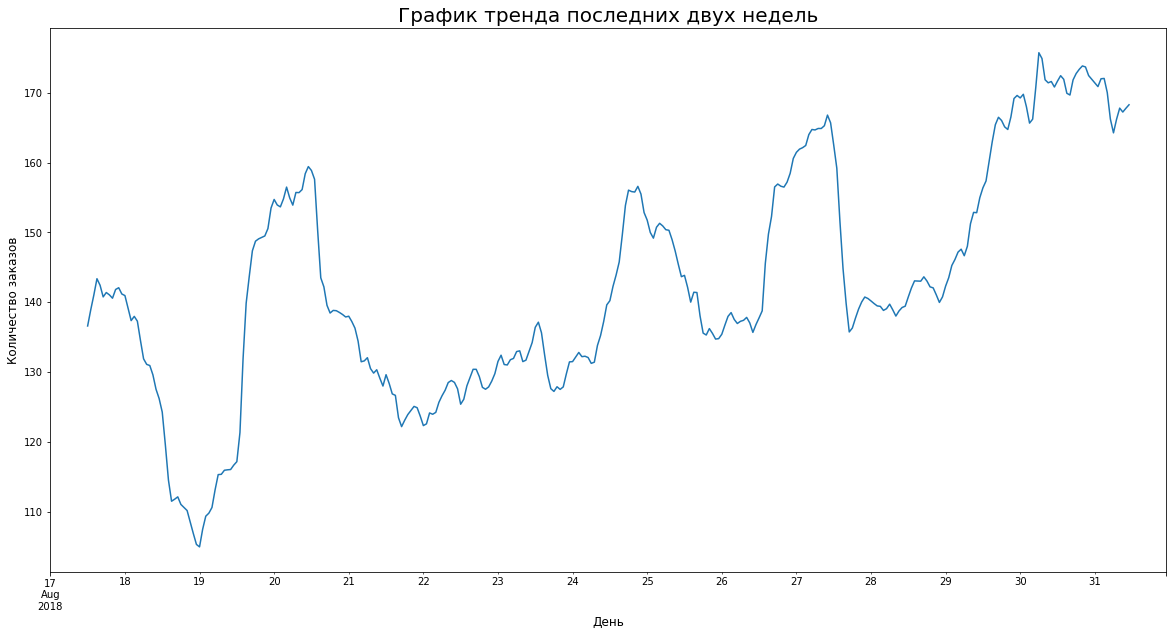

In [10]:
decomposed_time = seasonal_decompose(data['2018-08-17':'2018-08-31'])
plt.figure(figsize=(20, 10))
decomposed_time.trend.plot()
plt.title('График тренда последних двух недель', fontsize = 20)
plt.xlabel('День', fontsize = 12)
plt.ylabel('Количество заказов', fontsize = 12)
plt.show()

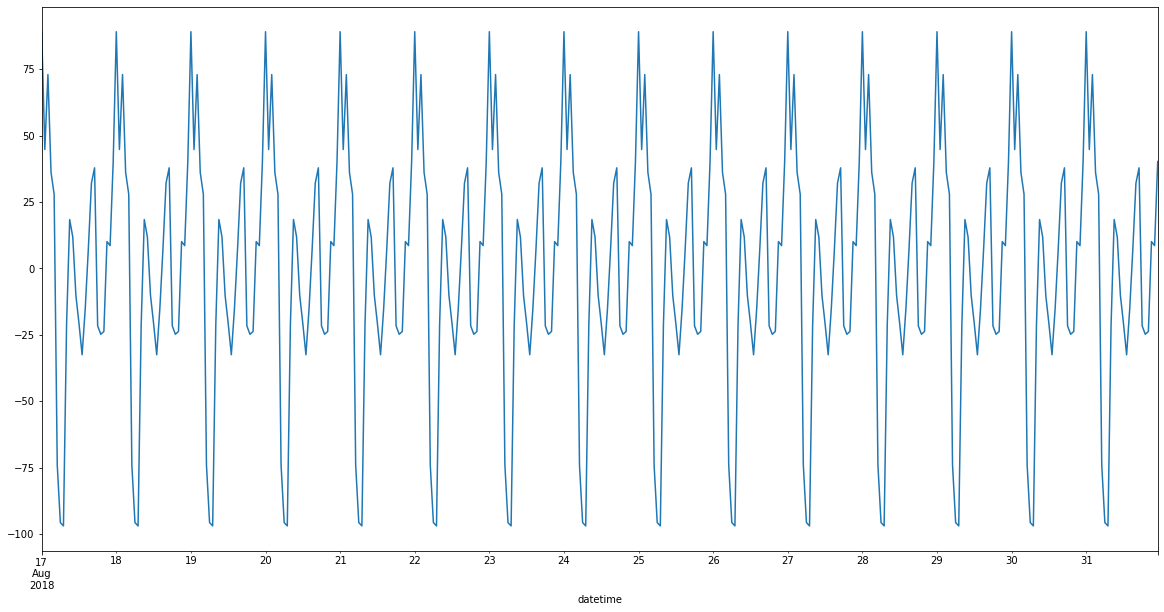

In [11]:
plt.figure(figsize=(20, 10))
decomposed_time.seasonal.plot()
plt.show()

<b>Вывод</b>

Из графика тренда за последние две недели особо ничего нового мы не узнаём: график также, в общем, понемногу возрастает, также присутствуют хаотичные скачки.

Из графика сезонности видно, что меньше всего заказов в первой половине дня, ближе к полудню, а больше всего - во второй половине, ближе к полуночи. Ещё можно отметить, что, если гипотеза о возрастании количества заказов в часы прилётов самолётов верна, то стабильно в аэропорт прибывает 5 самолётов, причём два из них, которые прибывают около полуночи, привозят больше людей, которые заказывают такси, чем остальные.

### Вывод

Несмотря на то, что график тренда идёт скачками, наблюдается медленное, но стабильное общее увеличение числа заказов, что может негативно сказаться на модели.

Скачки на графике явно связаны с прилётом самолётов. Судя по графику сезонности за последние две недели, стабильно в рассматриваемой аэропорт прилетают 5 самолётов (5 возрастающих отрезков за один период), причём эти самолёты разные по каким-то характеристикам (скорее всего, по вместимости), т.к. дают разный прирост к числу заказов. Если эта гипотеза верна, и количество заказов действительно зависит от графика прибытия самолётов, то этой информации явно не будет хватать для достижения наибольшей точности прогнозирующей модели.

## Создание признаков

Создадим следующие признаки:

- каледарные: месяц, число, день недели и час.

Месяц нам необходим, т.к. в общем, наблюдается тренд на медленное возрастание количества заказов, т.е. в начале марта количество заказов меньше, чем в начале августа. Это может быть связано как со временем года, так и с ростом компании (увеличение числа водителей, вложения в маркетинг и т.д.). Модели надо откуда-то узнать, что в общем количество заказов растёт, а узнать она это может только из информации о месяце.

Число и день недели может, например, говорить о самолётах, которые прибывают редко, например 2 раза в месяц или каждый понедельник. Мы не знаем, есть ли такие самолёт в расписании или нет, но учитывать такую возможность стоит. Кроме этого, эти признаки явно или косвенно могут говорить и о других зависимостях;

- отстающие значения

Судя по графику сезонности за последние две недели, период скачков составляет около суток, поэтому достаточно взять 48 отстающих значений, для того, чтобы модель "увидела" период;

- скользящее среднее

Скользящее среднее как признак задаёт общий тренд временного ряда. Общий тренд - медленное увеличение роста общего количества заказов. Судя по графику тренда за последние две недели, данный тренд наблюдается не каждые сутки, но, в среднем, точно присутствует в двух сутках, поэтому имеет смысл взять большое значение окна - около 48.

In [12]:
df = data.copy(deep=True)

In [13]:
def make_features(df, max_lag, rolling_sum_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return df

In [14]:
df = make_features(df, 48, 48)

display(df.head(3))
df.info()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   4416 non-null   int64  
 1   month        4416 non-null   int64  
 2   day          4416 non-null   int64  
 3   dayofweek    4416 non-null   int64  
 4   hour         4416 non-null   int64  
 5   lag_1        4415 non-null   float64
 6   lag_2        4414 non-null   float64
 7   lag_3        4413 non-null   float64
 8   lag_4        4412 non-null   float64
 9   lag_5        4411 non-null   float64
 10  lag_6        4410 non-null   float64
 11  lag_7        4409 non-null   float64
 12  lag_8        4408 non-null   float64
 13  lag_9        4407 non-null   float64
 14  lag_10       4406 non-null   float64
 15  lag_11       4405 non-null   float64
 16  lag_12       4404 non-null   float64
 17  lag_13       4403 non-null   float64
 18  lag_

In [15]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   4368 non-null   int64  
 1   month        4368 non-null   int64  
 2   day          4368 non-null   int64  
 3   dayofweek    4368 non-null   int64  
 4   hour         4368 non-null   int64  
 5   lag_1        4368 non-null   float64
 6   lag_2        4368 non-null   float64
 7   lag_3        4368 non-null   float64
 8   lag_4        4368 non-null   float64
 9   lag_5        4368 non-null   float64
 10  lag_6        4368 non-null   float64
 11  lag_7        4368 non-null   float64
 12  lag_8        4368 non-null   float64
 13  lag_9        4368 non-null   float64
 14  lag_10       4368 non-null   float64
 15  lag_11       4368 non-null   float64
 16  lag_12       4368 non-null   float64
 17  lag_13       4368 non-null   float64
 18  lag_

## Обучение

Для начала, рассмотрим стандартные модели, которые быстро реализуются и обучаются. Если их точности не хватит для выполнения условия задачи, тогда будем рассматривать другие варианты.

### Подготовка выборок

In [16]:
data_train, data_test = train_test_split(df, test_size=0.1, shuffle=False)

features_train = data_train.drop('num_orders', axis=1)

target_train = data_train['num_orders']
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.1, shuffle=False)
features_test = data_test.drop('num_orders', axis=1)
target_test = data_test['num_orders']

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [17]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

### Обучение модели линейной регрессии

Рассмотрим стандартную модель линейной регрессии.

In [18]:
# linearregression

model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

preds_train = model_linear.predict(features_train)
rmse_train = rmse(target_train, preds_train)

preds_valid = model_linear.predict(features_valid)
rmse_valid = rmse(target_valid, preds_valid)

print("RMSE обучающей выборки:", rmse_train)
print("RMSE тестовой выборки: ", rmse_valid)

RMSE обучающей выборки: 22.33397984096058
RMSE тестовой выборки:  31.270262614030248


<b>Вывод</b>

Стандартная модель линейной регрессии даёт на выходе необходимое значение метрики RMSE на валидационной выборке, меньше 48.

Посмотрим, как покажет себя модель градиентного бустинга

### Обучение моделей LGBMRegressor

Переберём, с помощью обычного цикла, модели LGBMRegressor с разными типами 'boosting_type' и гиперпараметрами к ним.

In [19]:
# Подбор парамтеров, дающих наилучшее значение контрольной метрики

boosting_types = ['gbdt', 'dart', 'goss']
best_model_list = []
best_result_list = []

with tqdm(total=231) as pbar:
    for value in boosting_types:

        best_result = 5000 
        best_leaf = 0
        best_est = 0
        best_model = None

        for leaf in range(40, 71, 5):
            for est in range(100, 201, 10):
                model = LGBMRegressor(boosting_type=value, num_leaves=leaf, n_estimators=est, random_state=12345)
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                result = rmse(predictions, target_valid)
                if result < best_result:
                    best_model = model
                    best_result = result
                pbar.update(1)

        best_model_list.append(best_model)
        best_result_list.append(best_result)

            
print('Лучший результат метрики RMSE у модели LGBRegressor равен', min(best_result_list))

100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [02:15<00:00,  1.71it/s]

Лучший результат метрики RMSE у модели LGBRegressor равен 30.454647872139113


<b>Вывод</b>

Как видим, лучшая из перебранных моделей LGBMRegressor также показывает значение, которое удовлетворяет заданному условию <48. Результат у такой модели на валидационной выборке немного лучше, чем у стандартной модели линейной регрессии

### Вывод

Оба рассмотренных типа моделей выдали необходимое значение на валидационной выборке. Рассматривать другие модели, на данном этапе, не имеет смысла, т.к. с большой вероятностью, поставленную задачу можно решить и рассмотренными моделями

## Сравнение моделей и тестирование наилучшей

### Сравнение

Сравним разные рассмотренные модели и визуализируем их результат на валидационной выборке

In [20]:
best_model_list.append(model_linear)

compare_models = pd.DataFrame(columns=['model_type', 'RMSE_valid', 'RMSE_test', 'model'])

compare_models['model_type'] = boosting_types
compare_models.loc[3, 'model_type'] = 'linear_regression'

best_result_list.append(rmse_valid)
compare_models['RMSE_valid'] = best_result_list

compare_models['model'] = best_model_list

display(compare_models)

,model_type,RMSE_valid,RMSE_test,model
0,gbdt,30.454648,NaN,"LGBMRegressor(n_estimators=190, num_leaves=70,..."
1,dart,32.158403,NaN,"LGBMRegressor(boosting_type='dart', n_estimato..."
2,goss,30.618880,NaN,"LGBMRegressor(boosting_type='goss', n_estimato..."
3,linear_regression,31.270263,NaN,LinearRegression()


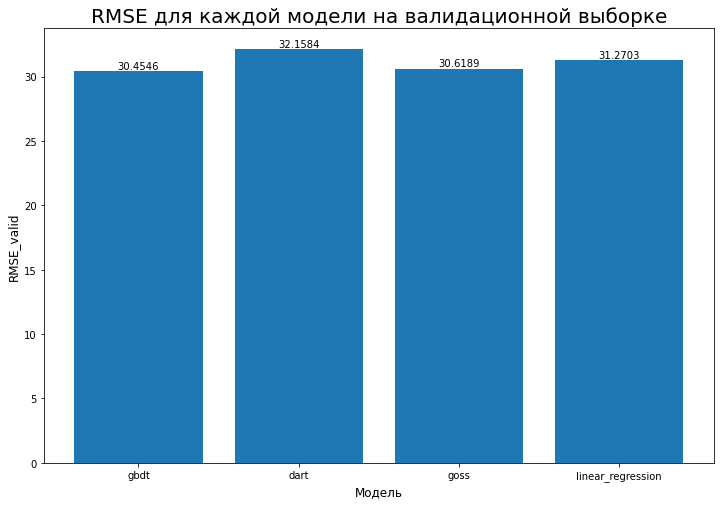

In [21]:

plt.figure(figsize=(12,8))
plt.bar_label(plt.bar(compare_models['model_type'], compare_models['RMSE_valid']))
plt.title('RMSE для каждой модели на валидационной выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('RMSE_valid', fontsize = 12)
plt.show()

<b>Вывод</b>

На валидационной выборке модели показывают примерно равные значения метрики RMSE. Возьмём для тестирования модель с наименьшим значением RMSE.

### Тестирование наилучшей

RMSE лучшей модели на тестовой выборке: 45.60568745964275


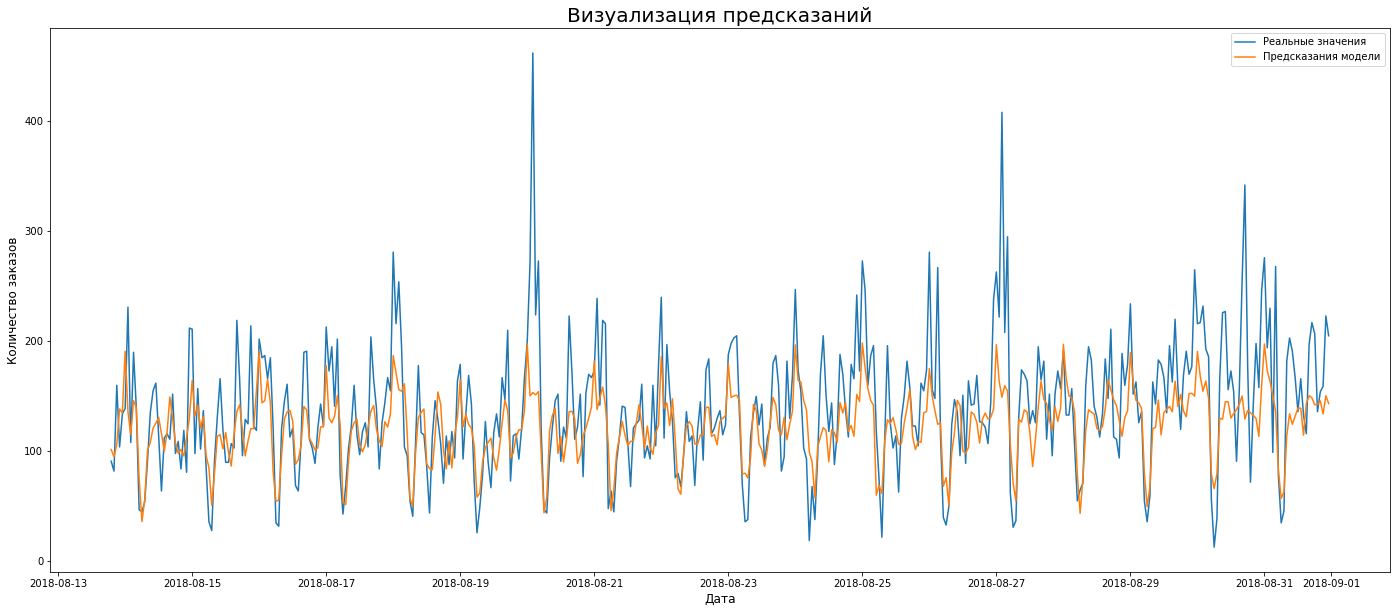

In [22]:
best_model = best_model_list[compare_models.loc[compare_models['RMSE_valid'] == compare_models['RMSE_valid'].min()].index[0]]
preds_test = best_model.predict(features_test)
result = rmse(target_test, preds_test)
print('RMSE лучшей модели на тестовой выборке:', result)

plt.figure(figsize=(24,10))
plt.plot(target_test.index, target_test, label='Реальные значения')
plt.plot(target_test.index, preds_test, label='Предсказания модели')
plt.title('Визуализация предсказаний', fontsize = 20)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Количество заказов', fontsize = 12)
plt.legend()
plt.show()

## Вывод

- <b>Нужное значение достигнуто</b>. Наилучшее значение метрики у модели LGBMRegressor, оно удовлетворяет заданному условию, что метрика RMSE на тестовой выборке меньше 48.

- из-за общего тренда на медленное возрастание количества заказов, моделям сложно определить следующие значения. На это указывает разница в значениях метрики RMSE на валидационной и тестовой выборках: по размеру эти выборки отличаются на 10% (валидационная выборка меньше), а по значениям метрики больше чем на 30%

- для увеличения точности модели стоит добавить признаки, которые будут связаны с расписанием прибытия самолётов: когда, откуда и какой самолёт прибывает. Это сделать уж точно реально, т.к. расписание прибытия известно заранее. Тогда предсказания станут точнее.